# Detector simulation
In this notebook we load a track dataset generated by `edep-sim` and we calculate the ADC counts corresponding to each pixel. The result is exported to a HDF5 file.

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
from math import ceil
from time import time

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import cupy as cp
import fire
import h5py

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100


from tqdm.notebook import tqdm

In [3]:
from larndsim import consts

consts.load_detector_properties("../larndsim/detector_properties/module0.yaml","../larndsim/pixel_layouts/multi_tile_layout-2.0.16.yaml")

from larndsim import quenching, drifting, detsim, pixels_from_track, fee

In [4]:
vref=1300
vcm=288
ped=580
gain = 4

In [5]:
a = h5py.File("../../edepsim_hdf_09/edep.202.h5")

In [6]:
b = h5py.File("../cli/test.202.v4.h5")

In [7]:
segments = a['segments'][:500000]

In [43]:
len(segments[np.abs(segments['pdgId'])==2212])

4388

In [8]:
reco_pairs = [[evid,trkid] for evid,trkid in zip(b['mc_packets_assn']['event_ids'][b['mc_packets_assn']['event_ids']>=0],
                                                 b['mc_packets_assn']['track_ids'][b['mc_packets_assn']['track_ids']>=0])]
unique_reco_pairs = np.unique(np.array(reco_pairs),axis=0)

In [9]:
from collections import defaultdict

In [55]:
tot_evids = np.unique(segments['eventID'])
# We divide the sample in portions that can be processed by the GPU
tracks_batch_runtimes = []
true_dE = defaultdict(lambda: 0)


for ievd in tqdm(range(0, tot_evids.shape[0], 1), desc='Simulating pixels...'):
    start_tracks_batch = time()
    first_event = tot_evids[ievd]
    last_event = tot_evids[min(ievd+1, tot_evids.shape[0]-1)]

    if first_event == last_event:
        last_event += 1

    evt_tracks = segments[(segments['eventID']>=first_event) & (segments['eventID']<last_event)]
    selected_tracks = evt_tracks[:500]
    for segment in selected_tracks:
        if abs(segment['pdgId']) == 11:
            true_dE[(segment['eventID'],segment['trackID'])] += segment['dE']

In [45]:
reco_dE = defaultdict(lambda: 0)
for pair in tqdm(unique_reco_pairs):
    if tuple(pair) in true_dE:
        reco_dE[tuple(pair)] = true_dE[tuple(pair)]

In [46]:
len(reco_dE.keys()), len(true_dE.keys())

(243, 264)

In [47]:
len(true_dE),len(reco_dE)

(264, 243)

(array([17.,  3.,  1.,  0.,  3.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  2.,
         5.,  1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30.]),
 <BarContainer object of 15 artists>)

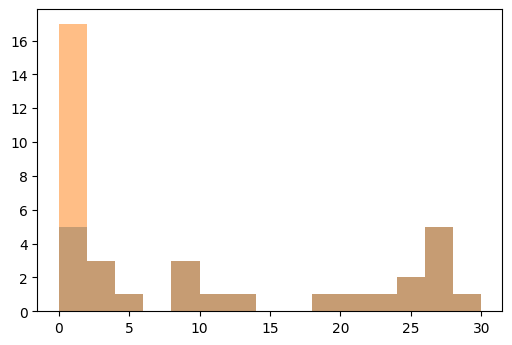

In [48]:
fig,ax=plt.subplots(1,1)
ax.hist(reco_dE.values(),range=(0,30),bins=15,alpha=0.5)
ax.hist(true_dE.values(),range=(0,30),bins=15,alpha=0.5)

/global/u1/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/global/u1/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, 'Reconstruction efficiency')

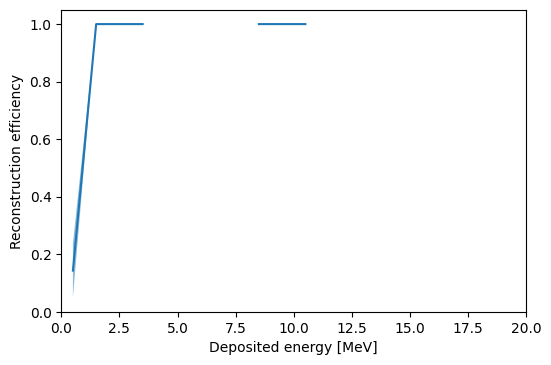

In [54]:
fig,ax = plt.subplots(1,1)
true_hist,bins = np.histogram(list(true_dE.values()),range=(0,20),bins=20)
reco_hist,bins = np.histogram(list(reco_dE.values()),range=(0,20),bins=20)
bin_centers = (bins[:-1] + bins[1:])/2.
eff = reco_hist/true_hist
err = 1/true_hist*np.sqrt(reco_hist*(1-eff))
ax.plot(bin_centers,eff)
ax.fill_between(bin_centers, eff-err, eff+err,alpha=0.5)
ax.set_ylim(0,1.05)
ax.set_xlim(0,20)
ax.set_xlabel("Deposited energy [MeV]")
ax.set_ylabel("Reconstruction efficiency")

In [ ]:
from matplotlib import colors

In [10]:
true_energy = defaultdict(lambda: 0)

for segment in tqdm(a['segments'][:100000]):
    if segment['eventID'] in tot_charge.keys():
#         print(segment['dE'])
        true_energy[segment['eventID']] += segment['dE']

NameError: name 'true_energy' is not defined

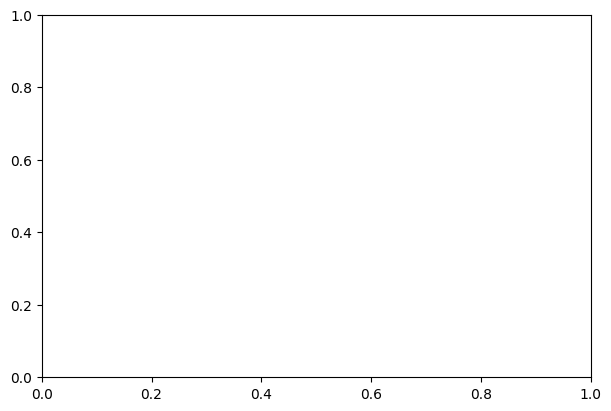

In [6]:
fig,ax=plt.subplots(1,1,constrained_layout=True)
import scipy.stats
from scipy.optimize import curve_fit

def lin_fit(x,m):
    return m*x

x = list(true_energy.values())
y =  list(tot_charge.values())

_=ax.hist2d(x,y,range=((0,300),(0,15000)),bins=50,norm=colors.LogNorm())
mean_result = scipy.stats.binned_statistic(x, y, bins=15, range=(10,300), statistic='mean')
mean = mean_result.statistic
bin_edges = mean_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
popt, pcov = curve_fit(lin_fit, bin_centers, mean)
x=np.linspace(0,1000,100)
ax.plot(x, lin_fit(x, *popt), lw=2, c='r', label=r'Fit: %.2f $10^3$e$^-$/MeV' % popt[0])
ax.plot(x, 42.37*x, ls='--', c='r', lw=2, label=r'1\W$_{\mathrm{LAr}}$: 42.37 $10^3$e$^-$/MeV')
ax.errorbar(x=bin_centers, y=mean,fmt='ro')
ax.set_xlabel("Deposited energy [MeV]")
ax.set_ylabel("Charge [10$^3$ e$^-$]")
ax.legend()
#_=ax.hist(np.array(list(true_energy.values())),bins=200,range=(0,500))
#_=ax.hist(np.array(list(tot_charge.values())),bins=200,range=(0,5000))

unique_pix = cp.empty((0,2))

### Dataset import
First of all we load the `edep-sim` output. For this sample we need to invert $z$ and $y$ axes.

In [5]:
unique_pix = cp.empty((0,2))
pixels_signals = cp.zeros((len(unique_pix), len(consts.time_ticks)*3))

In [6]:
with h5py.File('../../edepsim_hdf_09/edep.202.h5', 'r') as f:
    tracks = np.array(f['segments'])

x_start = np.copy(tracks['x_start'] )
x_end = np.copy(tracks['x_end'])
x = np.copy(tracks['x'])

tracks['x_start'] = np.copy(tracks['z_start'])
tracks['x_end'] = np.copy(tracks['z_end'])
tracks['x'] = np.copy(tracks['z'])

tracks['z_start'] = x_start
tracks['z_end'] = x_end
tracks['z'] = x

selected_tracks = tracks[:500]

In [7]:
%load_ext wurlitzer

### Quenching and drifting
We calculate the number of electrons after recombination (`quenching` module) and the position and number of electrons after drifting (`drifting` module).

In [8]:
TPB = 256
BPG = ceil(selected_tracks.shape[0] / TPB)
import importlib
importlib.reload(drifting)
quenching.quench[BPG,TPB](selected_tracks, consts.birks)
drifting.drift[BPG,TPB](selected_tracks)

We find the pixels intersected by the projection of the tracks on the anode plane using the Bresenham's algorithm. We also take into account the neighboring pixels, due to the transverse diffusion of the charges.

In [9]:
%load_ext wurlitzer
# Here we build a map between tracks and event IDs
unique_eventIDs = cp.unique(selected_tracks['eventID'])
event_id_map = cp.searchsorted(unique_eventIDs,cp.asarray(selected_tracks['eventID']))

longest_pix = ceil(max(selected_tracks["dx"])/consts.pixel_pitch)
max_radius = ceil(max(selected_tracks["tran_diff"])*5/consts.pixel_pitch)

MAX_PIXELS = int((longest_pix*4+6)*max_radius*1.5)
MAX_ACTIVE_PIXELS = int(longest_pix*1.5)

active_pixels = cp.full((selected_tracks.shape[0], MAX_ACTIVE_PIXELS, 2), -1, dtype=np.int32)
neighboring_pixels = cp.full((selected_tracks.shape[0], MAX_PIXELS, 2), -1, dtype=np.int32)
n_pixels_list = cp.zeros(shape=(selected_tracks.shape[0]))
TPB = 128
BPG = ceil(selected_tracks.shape[0] / TPB)
pixels_from_track.get_pixels[BPG,TPB](selected_tracks,
                                      active_pixels,
                                      neighboring_pixels,
                                      n_pixels_list,
                                      max_radius+1)

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [10]:
def cupy_unique_axis0(array):
    # axis is still not supported for cupy.unique, this
    # is a workaround
    if len(array.shape) != 2:
        raise ValueError("Input array must be 2D.")
    sortarr     = array[cp.lexsort(array.T[::-1])]
    mask        = cp.empty(array.shape[0], dtype=cp.bool_)
    mask[0]     = True
    mask[1:]    = cp.any(sortarr[1:] != sortarr[:-1], axis=1)
    return sortarr[mask]

shapes = neighboring_pixels.shape
joined = neighboring_pixels.reshape(shapes[0]*shapes[1],2)
this_unique_pix = cupy_unique_axis0(joined)
this_unique_pix = this_unique_pix[(this_unique_pix[:,0] != -1) & (this_unique_pix[:,1] != -1),:]

In [11]:
unique_pix = cp.concatenate((unique_pix, this_unique_pix),axis=0)

### Charge distribution calculation
Here we calculate the current induced by each track on the pixels, taking into account longitudinal and transverse diffusion. The track segment is parametrized as:
\begin{align}
x'(r') &=x_s + \frac{\Delta x}{\Delta r}r'\\
y'(r') &=y_s + \frac{\Delta y}{\Delta r}r'\\
z'(r') &=z_s + \frac{\Delta z}{\Delta r}r',
\end{align}
where $\Delta r$ is the segment length. Here we assume $z$ as the drift direction.
The diffused charge distribution is calculated with the following integral:
\begin{equation}
\rho(x,y,z) = \frac{Q}{\sqrt{(2\pi)^3}\sigma_x\sigma_y\sigma_z\Delta r}\exp\left[-\frac{(x-x_s)^2}{2\sigma_x^2}-\frac{(y-y_s)^2}{2\sigma_y^2}-\frac{(z-z_s)^2}{2\sigma_z^2}\right]\int^{r'=\Delta r}_{r'=0}dr'\exp[-(ar'^2+br')],
\end{equation}
where 
\begin{align}
a &= \left[\left(\frac{\Delta x}{\Delta r}\right)^2\frac{1}{2\sigma_x^2} + \left(\frac{\Delta y}{\Delta r}\right)^2\frac{1}{2\sigma_y^2} + \left(\frac{\Delta z}{\Delta r}\right)^2\frac{1}{2\sigma_z^2} \right]\\
b &= -\left[\frac{(x-x_s)}{\sigma_x^2}\frac{\Delta x}{\Delta r}+
\frac{(y-y_s)}{\sigma_y^2}\frac{\Delta y}{\Delta r}+
\frac{(z-z_s)}{\sigma_z^2}\frac{\Delta z}{\Delta r}\right].
\end{align}

The simmetry of the transverse diffusion along the track allows to take a slice on the $xy$ plane and solve the integral once at a fixed $z$ coordinate (e.g. at $z_{m} = (z_s+z_e)/2$) and re-use it at other $z$ coordinates away from the endpoints (where $\rho(x,y,z)$ varies along $z$ so must be calculated at each $z$). 

In [12]:
max_length = cp.array([0])
track_starts = cp.empty(selected_tracks.shape[0])
threadsperblock = 128
blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
detsim.time_intervals[blockspergrid,threadsperblock](track_starts, max_length,  event_id_map, selected_tracks)

In [13]:
signals = cp.zeros((selected_tracks.shape[0],
                    neighboring_pixels.shape[1],
                    cp.asnumpy(max_length)[0]), dtype=np.float32)
threadsperblock = (1,1,64)
blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
detsim.tracks_current[blockspergrid,threadsperblock](signals,
                                                     neighboring_pixels,
                                                     selected_tracks)

In [14]:
pixel_index_map = cp.full((selected_tracks.shape[0], neighboring_pixels.shape[1]), -1)
try:
    compare = neighboring_pixels[..., np.newaxis, :] == unique_pix
    indices = cp.where(cp.logical_and(compare[..., 0], compare[..., 1]))
except cp.cuda.memory.OutOfMemoryError:
    print("out of memory")
pixel_index_map[indices[0], indices[1]] = indices[2]

In [15]:
pixel_index_map.shape

(500, 273)

In [16]:
blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
this_pixels_signals = cp.zeros((len(this_unique_pix), len(consts.time_ticks)*3))
pixels_signals = cp.concatenate((pixels_signals, this_pixels_signals), axis=0)
detsim.sum_pixel_signals[blockspergrid,threadsperblock](pixels_signals,
                                                        signals,
                                                        track_starts,
                                                        pixel_index_map)
currents = np.sum(pixels_signals,axis=1)*consts.t_sampling/consts.e_charge

In [17]:
pixels_signals.sum()/consts.e_charge*consts.t_sampling/sum(tracks[0:500]['dE'])

array(42225.36895494)

### 3D event display

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(readonly array(float64, 3d, C), float64)
 
There are 16 candidate implementations:
  - Of which 14 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(readonly array(float64, 3d, C), float64)':
   No match.
  - Of which 2 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 162.
    With argument(s): '(readonly array(float64, 3d, C), float64)':
   Rejected as the implementation raised a specific error:
     TypeError: unsupported array index type float64 in [float64]
  raised from /global/u1/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/numba/core/typing/arraydecl.py:69

During: typing of intrinsic-call at /global/u1/s/soleti/larnd-sim/larndsim/detsim.py (234)

File "../larndsim/detsim.py", line 234:
def get_pixel_coordinates(pixel_id):
    <source elided>
    plane_id = pixel_id[0] // n_pixels[0]
    this_border = tpc_borders[plane_id]
    ^


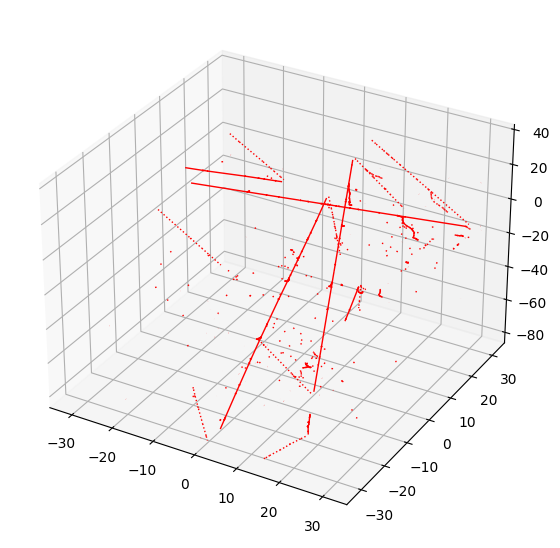

In [18]:
cmap = cm.Spectral_r
norm = colors.Normalize(vmin=0, vmax=256)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

cmap = cm.viridis
norm_curr = colors.LogNorm(vmin=1, vmax=max(currents))
m_curr = cm.ScalarMappable(norm=norm_curr, cmap=cmap)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for it,t in enumerate(selected_tracks):
    if it == 0:
        ax.plot((t["x_start"], t["x_end"]), 
            (t["z_start"], t["z_end"]),
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1,
            alpha=1,
            zorder=10,
            label='Geant4 detector segment')
    else:
        ax.plot((t["x_start"], t["x_end"]), 
                (t["z_start"], t["z_end"]),
                (t["y_start"], t["y_end"]),
                c='r',
                lw=1,
                alpha=1,
                zorder=9999)
        
    ax.plot((t["x_start"], t["x_end"]), 
            (consts.tpc_borders[t['pixel_plane']][2][0], consts.tpc_borders[t['pixel_plane']][2][0]),
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1,
            ls=':',
            alpha=1,
            zorder=9999)
        
for ip, p in enumerate(unique_pix):
    x_rect, y_rect = detsim.get_pixel_coordinates(p.get())
    pixel_plane = int(p[0] // consts.n_pixels[0])
    row = int(pixel_plane // 4)
    column = int(pixel_plane % 4)
    if currents[ip] > 0:
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.1, fc=m_curr.to_rgba(currents[ip].get()),
                             edgecolor='gray')
        ax.add_patch(rect)
        art3d.pathpatch_2d_to_3d(rect, z=consts.tpc_borders[pixel_plane][2][0], zdir="y")


        
anode1 = plt.Rectangle((consts.tpc_borders[0][0][0], consts.tpc_borders[0][1][0]),
                        consts.tpc_borders[0][0][1]-consts.tpc_borders[0][0][0], 
                        consts.tpc_borders[0][1][1]-consts.tpc_borders[0][1][0],
                       linewidth=1, fc='none',
                       edgecolor='gray', label=('Pixel' if ip == 5 else ''))
ax.add_patch(anode1)
art3d.pathpatch_2d_to_3d(anode1, z=consts.tpc_borders[0][2][0], zdir="y")

anode2 = plt.Rectangle((consts.tpc_borders[0][0][0], consts.tpc_borders[0][1][0]),
                        consts.tpc_borders[0][0][1]-consts.tpc_borders[0][0][0], 
                        consts.tpc_borders[0][1][1]-consts.tpc_borders[0][1][0],
                       linewidth=1, fc='none',
                       edgecolor='gray', label=('Pixel' if ip == 5 else ''))
ax.add_patch(anode2)
art3d.pathpatch_2d_to_3d(anode2, z=consts.tpc_borders[1][2][0], zdir="y")

cathode = plt.Rectangle((consts.tpc_borders[0][0][0], consts.tpc_borders[0][1][0]),
                        consts.tpc_borders[0][0][1]-consts.tpc_borders[0][0][0], 
                        consts.tpc_borders[0][1][1]-consts.tpc_borders[0][1][0],
                        linewidth=1, fc='gray', alpha=0.5,
                        edgecolor='gray', label=('Pixel' if ip == 5 else ''))
ax.add_patch(cathode)
art3d.pathpatch_2d_to_3d(cathode, z=0, zdir="y")

ax.plot((consts.tpc_borders[0][0][0],consts.tpc_borders[0][0][0]),(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0]),
        (consts.tpc_borders[0][1][0],consts.tpc_borders[0][1][0]), lw=1,color='gray')

ax.plot((consts.tpc_borders[0][0][0],consts.tpc_borders[0][0][0]),(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0]),
        (consts.tpc_borders[0][1][1],consts.tpc_borders[0][1][1]), lw=1,color='gray')

ax.plot((consts.tpc_borders[0][0][1],consts.tpc_borders[0][0][1]),(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0]),
        (consts.tpc_borders[0][1][0],consts.tpc_borders[0][1][0]), lw=1,color='gray')

ax.plot((consts.tpc_borders[0][0][1],consts.tpc_borders[0][0][1]),(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0]),
        (consts.tpc_borders[0][1][1],consts.tpc_borders[0][1][1]), lw=1,color='gray')



# ax.set_ylim(consts.module_borders[pixel_plane][2][0],50)
ax.set_xlim(consts.tpc_borders[0][0][0],consts.tpc_borders[1][0][1])
ax.set_ylim(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0])
ax.set_zlim(consts.tpc_borders[0][1][0],consts.tpc_borders[1][1][1])

ax.set_box_aspect((2,2,4))
ax.grid(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
# ax.set_axis_off()
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.view_init(azim=20)
# def rotate(angle):
#     ax.view_init(azim=angle)
    
# from matplotlib import animation

# rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=50)

ax.set_ylabel("z [cm]")
ax.set_xlabel("x [cm]")
ax.set_zlabel("y [cm]")
_ = plt.colorbar(m_curr,fraction=0.035, pad=0.05,label='Induced current integral [# electrons]')


In [33]:
# rot_animation.save('animation.gif', writer='imagemagick', fps=10, bitrate=10, dpi=100)

### Electronics response and digitization 
Here we simulate the electronics response (the self-triggering cycle) and the signal digitization.

In [19]:
time_ticks = cp.linspace(0, len(unique_eventIDs)*consts.time_interval[1]*2, pixels_signals.shape[1]+1)
integral_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
adc_ticks_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
TPB = 128
BPG = ceil(pixels_signals.shape[0] / TPB)

rng_states = create_xoroshiro128p_states(TPB * BPG, seed=0)
fee.get_adc_values[BPG,TPB](pixels_signals,
                            time_ticks,
                            integral_list,
                            adc_ticks_list,
                            0,
                            rng_states)
adc_list = fee.digitize(integral_list)

### 2D event display with induced current and ADC counts

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(readonly array(float64, 3d, C), float64)
 
There are 16 candidate implementations:
  - Of which 14 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(readonly array(float64, 3d, C), float64)':
   No match.
  - Of which 2 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 162.
    With argument(s): '(readonly array(float64, 3d, C), float64)':
   Rejected as the implementation raised a specific error:
     TypeError: unsupported array index type float64 in [float64]
  raised from /global/u1/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/numba/core/typing/arraydecl.py:69

During: typing of intrinsic-call at /global/u1/s/soleti/larnd-sim/larndsim/detsim.py (234)

File "../larndsim/detsim.py", line 234:
def get_pixel_coordinates(pixel_id):
    <source elided>
    plane_id = pixel_id[0] // n_pixels[0]
    this_border = tpc_borders[plane_id]
    ^


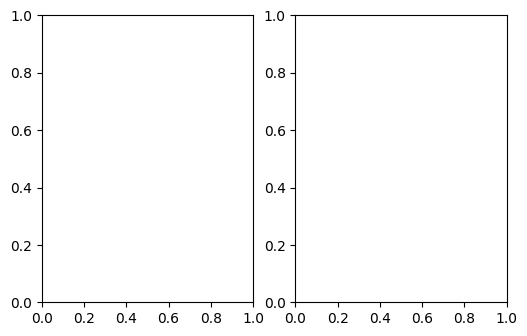

In [20]:
fig,ax = plt.subplots(1,2,figsize=(6,3.8))

for ip, p in enumerate(unique_pix):
    x_rect, y_rect = detsim.get_pixel_coordinates(p.get())
    pixel_plane = int(p[0] // consts.n_pixels[0])
    c = currents[ip].get()
    if c >= 1:    
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.2, fc=m_curr.to_rgba(c),
                             edgecolor='grey')
        ax[0].add_patch(rect)

    a = adc_list[ip][adc_list[ip]>fee.digitize(0)]
    if len(a):    
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.2, fc=m.to_rgba(np.sum(a.get())),
                             edgecolor='grey')
        ax[1].add_patch(rect)


for it,t in enumerate(selected_tracks):
    ax[0].plot((t["x_start"], t["x_end"]), 
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1.25,
            ls=':',
            alpha=1,
            zorder=10)
    ax[1].plot((t["x_start"], t["x_end"]), 
            (t["y_start"], t["y_end"]),
            c='r',
            lw=0,
            ls=':',
            alpha=1,
            zorder=10)
    ax[0].scatter((t["x_start"], t["x_end"]), 
                  (t["y_start"], t["y_end"]),
                  c='r', s=1, zorder=99999)
#     ax[1].scatter((t["x_start"], t["x_end"]), 
#                   (t["y_start"], t["y_end"]),
#                   c='r', s=1, zorder=99999)       

ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[0].set_xlabel("x [cm]")
ax[1].set_xlabel("x [cm]")
ax[0].set_ylabel("y [cm]")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

divider0 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m, ax=ax[1], cax=cax0, label='ADC counts sum')

divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m_curr, ax=ax[0], cax=cax1, label='Induced current integral [# electrons]')

plt.subplots_adjust(hspace=0.5)
fig.savefig("currentadc.pdf")

In [21]:
(np.sum(integral_list)/consts.e_charge/1000/sum(selected_tracks['dE']))

array(40.89317617)

In [22]:
42.37/((np.sum(adc_list[adc_list > 73]/256. * (vref-vcm) + vcm - ped)/gain/sum(selected_tracks['dE'])))

array(1.05347198)

### Export result
As a last step we backtrack the ADC counts to the Geant4 tracks and we export the result in a HDF5 file.

In [23]:
for ip in tqdm(range(a['packets'].shape[0])):
    p = a['packets'][ip]
    p_mc = a['mc_packets_assn'][ip]
    if p['packet_type'] == 0:
        q_raw = p['dataword']/256. * (vref-vcm) + vcm - ped
        if p_mc['event_ids'][0] < 0:
            tot_charge[last_evid] += q_raw/gain
        else:
            tot_charge[p_mc['event_ids'][0]] += q_raw/gain
            last_evid = p_mc['event_ids'][0]

NameError: name 'a' is not defined

In [27]:
MAX_TRACKS_PER_PIXEL = 5

# Mapping between unique pixel array and track array index
track_pixel_map = cp.full((unique_pix.shape[0], MAX_TRACKS_PER_PIXEL), -1)
TPB = 32
BPG = ceil(unique_pix.shape[0] / TPB)
detsim.get_track_pixel_map[BPG, TPB](track_pixel_map, unique_pix, neighboring_pixels)

# Here we backtrack the ADC counts to the Geant4 tracks
TPB = 128
BPG = ceil(adc_list.shape[0] / TPB)
backtracked_id = cp.full((adc_list.shape[0], adc_list.shape[1], MAX_TRACKS_PER_PIXEL, 2), -1)

detsim.backtrack_adcs[BPG,TPB](selected_tracks,
                               adc_list,
                               adc_ticks_list,
                               track_pixel_map,
                               event_id_map,
                               unique_eventIDs,
                               backtracked_id)

In [35]:
np.unique(backtracked_id[backtracked_id>0]), unique_eventIDs

(array([  1,   2,   8,  29,  39,  81, 100, 108]),
 array([  2,  29,  34,  37,  39,  59,  64,  81, 100, 108], dtype=uint32))

In [18]:
!rm test.h5
pc = fee.export_to_hdf5(adc_list.get(),
                        adc_ticks_list.get(),
                        unique_pix.get(),
                        backtracked_id.get(),
                        "test.h5")

Writing to HDF5...: 100%|██████████| 2195/2195 [00:00<00:00, 38628.71it/s]


In [19]:
with h5py.File('test.h5', 'r') as f:
    print(f['packets']['dataword'])

[  0  90  97  96 104  78  90 106  98 107  79  79  91  98  99  97  81  83
  91  98  98  97  82  84  92 100  99 103 100  82  92  98  98  97  81  92
 100  81 102 100  99  97  79  84 100  98 100  97  83  83  92 102 101  99
 119  87 100  98  84  88  80  83  92 114  96  92 100 100  99  82  93 112
 111 112  82  92 101 103 100  81  91  98 120 100  93  92  97 100 100  91
  90  97 107 101  93  82  97  99  99  91  90  95  97 119  97  89  97  99
 102  89  92  97  98  95  89  90  97  97  96  82  84  90  99  98  95  81
  82  97 124  85 113  96  81  91  80 107  96  88  95 102 106 117  84 103
  78  93  93  97 100  92 108  95  92  95  95 106  91  92  86  92 105  97
  95  90  82  99  96  96  97 106 105  83  82  97  95  95  97  80  84  90
  96  97  97  89  90  95  95  97  89  81  98  96  96  96  81  81 103  98
 120  79  97  81  90 102  97  99  90  89 102 117 104 114  91  86  99  96
  90  96 101  95  98  89  95 116  96  90 106  99  94 105  90 109  85  85
 100  91  98  88  88 107  93 122  79  89  85  80  9